### COM361 &mdash; Introdução a Otimização &mdash; 2022, Prof. Amit ###

# Event triggered social media chatter model - Julia implementation #

#### Gabriel José Souza e Silva (gabriel.jsss@poli.ufrj.br), Matheus Marinatto (marinattomatheus@poli.ufrj.br)


### Contents ###

1. Introduction and problem description
2. Mathmatical modeling

## 1. Introduction and problem description ##

This project's goal is to describe and explore a social marketing-based model for information spread, testing different control techniques so to determine which one provides better results. An important constraint for most marketing campaigns nowadays is the advertising cost, therefore a key goal for dispersing a message is to do that as efficiently and possible respecting budget and time constraints. From that, many optimization problems can be formulated. The following question, described in [1] gives the reason for such models to exist:

> At a high level, how does an organization sell to someone? Typically, individuals or groups (like marketing agencies) are enlisted as message spreaders who broadcast that information in a variety of formats including billboards, social media posts, and television advertisements.
> 

So in order to sell, it's necessary to spread information and the further question would be **how to maximize sells (and information spread) while minimizing costs**.

In [1], the approach to design an advertising model starts from the well established Vidale-Wolfe marketing model with some tweaks to better handle the social media dynamics. Quoting [2]:

> The Vidale-Wolfe marketing model is a first-order, linear, nonhomogeneous ordinary differential equation (ODE) where the forcing term is proportional to advertising expenditure. With an initial response in sales as the initial condition, the solution of the initial value problem is straightforward for a first undergraduate ODE course.
> 

Mathematically, this model is described as follows:

 $\frac{dS(t)}{dt} = \beta u(t)[M(t) - S(t)] - \delta S(t)$

where

- S(t) → Sales at time t;
- M(t) → Market size at time t;
- $\beta$ → Advertising constant;
- $\delta$ → Rate of brand sale decay;
- $u(t)$ → Control action at time t.

Most of the terms above are self-explanatory but $\beta$, which is described in [1] as “[…] the rate of decay of brand sale given no active advertising.”

From that, the Event-triggered Social Media Chatter Model is derived by doing the following:

1. Normalizing Vidale-Wolfe's model by setting $M(t) = 1$;
2. Breaking $\beta$ into two other constants:
    1. $\beta_1$ → the social marketing campaign constant;
    2. $\beta_2$ → the social interaction constant;
3. Generalizing the sales term $S(t)$ to an information spread value $X_t$.

In [1] the meaning of these constants is explained in the following paragraph

> The effectiveness of social marketing is affected by dynamic resource spending and promotion over the network to convince people to purchase a product, uphold a social or political movement, or join in an activity. The social marketing constant can be associated with a traditional advertising campaign or an event that triggers similar social media interest. Once people become exposed to an advertisement and decide to share the message, the social interaction constant may be viewed as the natural tendency of the social media network to advertise internally through posts, tweets, and likes without external influences and advertising.
> 

The final mathematical model is 

$$
dX_t = \beta_1 u(t)[1 - X_t] + \beta_2 [1 - X_t] X_t - \delta X_t
$$

or visually 

![Model](./assets/model.png)

The final definition to be presented is the concept of socio-equilibrium threshold. It basically describes the equilibrium level of social media chatter after the control (promotion) goes to 0 or mathematically

$$
X_{eqb} = 1 - \frac{\delta}{\beta_2}
$$

In [1], $\beta_2$ is multiplied by a factor k, but in this project the value of k will be embedded in $\beta_2$. Finally, the “[…] goal of social media marketing is to increase peoples’ attention and interest beyond the natural equilibrium point through the control action of spending resources on ads…” and at the same time minimizing the associated costs.



## 2. Mathematical model ##

During a marketing campaign, **the goal is to achieve social craze status as fast as possible while keeping costs as low as possible**. From that the optimization problem will be derived. The cost function for the Event-triggered Social Media Chatter Model is defined in [1] as 

$$
J = \int_{0}^{t_f}  [u^2(t) + (x-x_d)^2 + \lambda] dt
$$

where 

- $\lambda$  → weight placed on time. Meaning the importance of how long it takes to get to equilibrium;
- $x_d$ → desired amount of activity.

when there's no need to maintain $x_d$, $u(t)= 0$. Now the mentioned equations will be discretized, so they can be used in future simulations:

- Event-triggered Social Media Chatter Model:

$$
x(t+1) - x(t) = \beta_1 u(t)[1 - x(t)] + \beta_2 [1 - x(t)] x(t) - \delta X_t
$$

- Cost function:

$$
J = \sum_{k=0}^{T_F}(u^2(t) + (x(t) - x_d(t))^2 + \lambda)
$$

- Equilibrium point:

$$
X_{eqb} = 1 - \frac{\delta}{\beta_2}
$$

Gathering these equations, the optimization problem can be formulated as

$$
\begin{aligned}\underset{u}{\text{minimize}}\qquad& J(u, x) \\\text{subjected to:}\qquad& u_i \ge 0 && i=1,\dots,m\\& x_{i+1} = x_i + \beta_1 u_i[1 - x_i] + \beta_2 [1 - x_i] x_i - \delta x_i \\& x_i \ge 0\end{aligned}
$$

More constraints may be added according to the control technique used. The constants used are defined in the cell below, following the same as used in the snipet on page 151 of [1]

In [6]:
import Pkg; 
Pkg.add("JuMP");
Pkg.add("Clp");
Pkg.add("PyPlot");
Pkg.add("Ipopt");

@time using Clp;
@time using JuMP;
@time using PyPlot;
@time using Ipopt;

δ = 0.1; #forgetting factor
β1 = 0.1; #spreading constant
β2 = 0.15; #social spreading
λ = 1; #time cost weight
xEquilibrium = 1-(δ/β2);

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


  0.000207 seconds (180 allocations: 13.742 KiB)
  0.000201 seconds (180 allocations: 13.742 KiB)
  0.000214 seconds (180 allocations: 13.742 KiB)
  0.000199 seconds (180 allocations: 13.742 KiB)


## 3. Solução ##

Nesta seção, coloque seu código em Julia + JuMP e resolva o problema proposto. Seu código deve ser limpo (não macarrônico!), de fácil leitura, bem comentado e anotado e deve compilar sem erros em Julia 1.x, x$\geq 1$! Não valem códigos em outras linguagens. **Vou rodar seu código para avaliar seu projeto**. Sugiro a utilização de múltiplos blocos de códigos separados por blocos de texto (células Markdown) explicando as várias partes da sua solução. Sugiro também a resolução de várias versões do seu problema, com modelos e hipóteses diferentes.

É permitido chamar pacotes externos, mas evite a utilização de bibliotecas exóticas (pois, em geral, não rodam em todas as versões de Julia, e terei que instalar a mesma versão que você usou, ou rodar na plataforma Google Colab, que gostaria de evitar).

100.00000012857558
[0.33320922352713994, 0.3332176527573166, 0.3332254150623669, 0.3332325782045923, 0.33323920193715995, 0.33324533868314693, 0.33325103431068914, 0.33325632894774687, 0.33326125777059507, 0.33326585172500806, 0.33327013815980117, 0.3332741413687606, 0.3332778830466622, 0.333281382669204, 0.33328465780768163, 0.3332877243889323, 0.33329059691021823, 0.3332932886175451, 0.3332958116545502, 0.3332981771877302, 0.33330039551256435, 0.3333024761440961, 0.33330442789476816, 0.33330625894172367, 0.33330797688534225, 0.3333095888004432, 0.33331110128131924, 0.3333125204815552, 0.33331385214941434, 0.3333151016594395, 0.3333162740408015, 0.333317374002839, 0.3333184059581592, 0.3333193740436073, 0.3333202821393661, 0.3333211338864056, 0.3333219327024711, 0.33332268179677116, 0.33332338418350504, 0.3333240426943508, 0.3333246599900187, 0.33332523857096297, 0.3333257807873312, 0.33332628884822296, 0.3333267648303187, 0.3333272106859334, 0.33332762825054313, 0.3333280192498263, 0

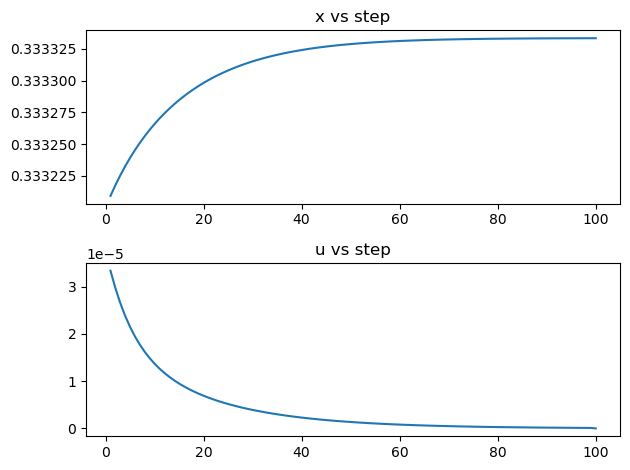

In [33]:
m = Model(Ipopt.Optimizer);
set_silent(m);
numberOfIterations = 100;
@variable(m, xOptimalControl[1:numberOfIterations] >= 0);        
@variable(m, uOptimalControl[1:numberOfIterations] >= 0);

for t in 1:numberOfIterations-1
    @constraint(m, xOptimalControl[t+1] == xOptimalControl[t] + β1*uOptimalControl[t]*(1 - xOptimalControl[t]) + β2*(1 - xOptimalControl[t])*xOptimalControl[t] - δ*xOptimalControl[t]);
end

@constraint(m, uOptimalControl[numberOfIterations] == 0);
@constraint(m, xOptimalControl[numberOfIterations] == xEquilibrium);
@constraint(m, sum(xOptimalControl) >= 0);
@constraint(m, sum(uOptimalControl) >= 0);

@constraint(m, xOptimalControl[1] <= 1000) #prevent explosion
@constraint(m, uOptimalControl[1] <= 1000) #prevent explosion

@objective(m, Min, sum(
    uOptimalControl .* uOptimalControl .+ (xOptimalControl .- xEquilibrium).*(xOptimalControl .- xEquilibrium) .+ λ
));
optimize!(m);

println(JuMP.objective_value.(m))
println(JuMP.value.(xOptimalControl));
println(JuMP.value.(uOptimalControl));

####### exporting variables for further analysis ########
costOptimalControlResult = JuMP.objective_value.(m);
xOptimalControlResult = JuMP.value.(xOptimalControl);
uOptimalControlResult = JuMP.value.(uOptimalControl);

##### plotting #######
clf(); #required for vscode on mac 
fig = plt.figure();

ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(range(1, numberOfIterations), transpose(JuMP.value.(xOptimalControl)));

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(range(1, numberOfIterations), transpose(JuMP.value.(uOptimalControl)));

fig.tight_layout();
show()
gcf()

**Tenha certeza de que seu código compila corretamente! Rodarei seu código!**

## 4. Resultados e discussão ##

Neste seção, os resultados obtidos serão exibidos e discutidos. Mostre figuras, gráficos, imagens, curvas de compromisso, e o que mais puder melhor ilustrar seus resultados. A discussão deverá explicar o que significam os resultados e como interpretá-los. As limitações da sua abordagem/modelo também devem ser colocadas, bem como uma análise da sensibilidade dos resultados em relação às hipóteses feitas.


Utilize plots (veja exemplos  `PyPlot` [aqui](https://gist.github.com/gizmaa/7214002))

Aqui está um exemplo de uma tabela (em Markdown):

| Tabelas        | São           | Boas  |
| ------------- |:-------------:| -----:|
| col 3 é      | alinhado à direita |\$1600 |
| col 2 é      | centrado      |  \$12 |
| texto | também serve      |   \$1 |

### 4.A. Subseções devem ser utilizadas para organizar seu texto.

#### 4.A.a. ou até subsubseções.

## 5. Conclusão ##

Faça um resumo do que encontrou e dos seus resultados, e fale de pelo menos uma direção na qual  seu trabalho pode ser desenvolvido no futuro, algo que poderia ser interessante em decorrência do seu projeto.


## 6. Referências bibliográficas ##

Nesta seção, cite _*todas*_ as referências utilizadas, na formulação matemática, no código ou para extrair dados ou figuras. Omissão de fontes é transgressão grave, denominada plágio.